# Where will the next Waitrose be built?

Disclaimer: Waitrose themselves are unaware of this work, and I have no connection with Waitrose or John Lewis.

Waitrose is a supermarket in the UK. It is perceived to be [more expensive](https://www.telegraph.co.uk/finance/newsbysector/retailandconsumer/10538240/Changing-the-upmarket-perception-of-Waitrose.html), associated with the [more well-off](https://www.theguardian.com/uk/2011/jun/29/waitrose-lidl-shopper-divided-britain)  and linked to [Conservative-run councils](https://www.thesun.co.uk/news/3745561/waitrose-shoppers-are-tories-ukippers-prefer-aldi-and-sainsburys-customers-vote-labour-what-does-your-supermarket-choice-on-how-youll-vote-tomorrow/) - and can even [increase house prices](https://www.independent.co.uk/property/house-prices-latest-waitrose-effect-sainsburys-marks-and-spencer-uk-property-a7760926.html).

In this project, I will aim to find the location of all current Waitrose stores, determine the kinds of neighbourhoods that they are a part of, and try to determine whether there are similar neighbourhoods in the UK which don't yet have a Waitrose, and could have one.

Given the limited Foursquare calls it may be useful to limit the scope of the "search area" - for example to England, or Hampshire.

### Data required

The data required will come from a variety of sources:
- Waitrose [A-Z store finder](https://www.waitrose.com/content/waitrose/en/bf_home/branch_finder_a-z.html) has a list of stores ( Each store has its own [web page](https://www.waitrose.com/content/waitrose/en/bf_home/bf/632.html). I will need to grab the list of stores from the A-Z page, and then the location of each store from the store page.
- A list of postcode to Location details including lat lon, and constituency is [here](https://www.doogal.co.uk/PostcodeDownloads.php) 
- The political party for the constituency under which the Waitrose store currently sits - from [UK Parliament](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-7979). 
- The top local amenities around the supermarket from Foursquare



### Get Waitrose Store details

Get A-Z of stores and store locally as file

In [2]:
import requests # For loading web pages
import numpy as np # For number manipulation
import pandas as pd # For data frame
from bs4 import BeautifulSoup # scraping web page
import matplotlib.pyplot as plt # for manipulating charts 
import seaborn as sns # For charts
from sklearn.cluster import KMeans 
import scipy.stats as stats

In [2]:
url = 'https://www.waitrose.com/content/waitrose/en/bf_home/branch_finder_a-z.html'
r = requests.get(url, allow_redirects=True)
open('branch_finder_a-z.html', 'wb').write(r.content)

82474

Create DataFrame with the Store name and URLs

In [3]:

# Load file saved above into BeautifulSoup renderer
with open("branch_finder_a-z.html") as fp:
    soup = BeautifulSoup(fp)

# Select all hrefs which have the letters bf (branch finder) in.
rows = soup.select('a[href*="bf"]')
pd.options.display.max_colwidth = 120

# There are a few header rows we don't want, and some blank rows. 
df = pd.DataFrame(columns=['Store name','Store URL'])
for idx, row in enumerate(rows):
    name = row.get_text()
    
    # I'm also extracting the URL column. Some URLS have domain, some don't - so adding if not.

    if (str(row['href'])[:5]!='http:'):
        url = 'https://www.waitrose.com/'+row['href']
    else:
        url = row['href']
    if (idx>2 and name!='' and name!='Branch Finder'):
        df = df.append({'Store name' : name , 'Store URL' : url} , ignore_index=True)

df.head()

Store name  \
0   Abergavenny   
1      Abingdon   
2    Addlestone   
3  Admiral Park   
4      Alcester   

                                                           Store URL  
0  https://www.waitrose.com//content/waitrose/en/bf_home/bf/683.html  
1  https://www.waitrose.com//content/waitrose/en/bf_home/bf/211.html  
2                      https://www.waitrose.com//bf_home/bf/542.html  
3    http://www.waitrose.com/content/waitrose/en/bf_home/bf/335.html  
4  https://www.waitrose.com//content/waitrose/en/bf_home/bf/474.html

Both the short and long URLs in the table above work OK. 

Now we need the Postcode for each store. So I will store the pages locally and extract the Postcodes, by creating a function for one URL, and applying it to all the entries in the dataframe.

In [4]:
def getAddress(urlToGet):
    r = requests.get(urlToGet, allow_redirects=True)
    
    localname = urlToGet[-8:]
    open(localname, 'wb').write(r.content)
    
    with open(localname) as fp:
        soup = BeautifulSoup(fp)
        rows = soup.find_all('div', {'class':'branch-details'})
       # rows = rows.find_all('p')
        address=str(rows[0].p).replace('\n','').replace(' ','').replace('\t','').replace('<br/>',',')
    return address[3:-6]

pc = getAddress("https://www.waitrose.com/content/waitrose/en/bf_home/bf/511.html")
print(pc)
addr = pc.split(',')
print (addr[-1])
print (addr[-2])
print(addr[-3])

Waitrose,MalmesburyBy-Pass,Malmesbury,SN169FS,0166682502
0166682502
SN169FS
Malmesbury


Now we can revise the original code to get each address and add the columns to the dataframe

In [5]:
import pandas as pd #For data frame
from bs4 import BeautifulSoup # scraping web page

# Load file saved above into BeautifulSoup renderer
with open("branch_finder_a-z.html") as fp:
    soup = BeautifulSoup(fp)

# Select all hrefs which have the letters bf (branch finder) in.
rows = soup.select('a[href*="bf"]')
pd.options.display.max_colwidth = 120

# There are a few header rows we don't want, and some blank rows. 
df = pd.DataFrame(columns=['Store name','Store URL','Area','Postcode','Phone'])
for idx, row in enumerate(rows):
    name = row.get_text()
    print(row)
    # I'm also extracting the URL column. Some URLS have domain, some don't - so adding if not.

    if (str(row['href'])[:5]!='http:'):
        url = 'https://www.waitrose.com/'+row['href']
    else:
        url = row['href']
    # Skip the first few rows, Branch Finder entry, and Peterborough which is a closed store but hasn't been removed
    if (idx>2 and name!='' and name!='Branch Finder' and name!='Peterborough'):
        pc = getAddress(url)
        addr = pc.split(',')
        df = df.append({'Store name' : name , 'Store URL' : url, 'Area': addr[-3], 'Postcode': addr[-2], 'Phone': addr[-1]} , ignore_index=True)

df

<a class="find-a-branch" href="/content/waitrose/en/bf_home/bf.html" target="_self"><span class="waitrose-glyph waitrose-glyph-find-a-branch"></span>Find a Branch</a>
<a href="/content/waitrose/en/bf_home/branch_finder_a-z.html">
			Branch Finder A-Z
		</a>
<a class="home" href="/content/waitrose/en/bf_home.html">Home</a>
<a href="/content/waitrose/en/bf_home/bf/683.html">Abergavenny</a>
<a href="/content/waitrose/en/bf_home/bf/211.html">Abingdon</a>
<a href="/bf_home/bf/542.html">Addlestone</a>
<a href="http://www.waitrose.com/content/waitrose/en/bf_home/bf/335.html">Admiral Park</a>
<a href="/content/waitrose/en/bf_home/bf/474.html">Alcester</a>
<a href="/content/waitrose/en/bf_home/bf/137.html"></a>
<a href="http://www.waitrose.com/content/waitrose/en/bf_home/bf/560.html">Alderley Edge</a>
<a href="/content/waitrose/en/bf_home/bf/137.html">Allington Park</a>
<a href="http://www.waitrose.com/content/waitrose/en/bf_home/bf/329.html">Alton</a>
<a href="/content/waitrose/en/bf_home/bf/4

KeyboardInterrupt: 

In [3]:
# The above cell takes a while to run, so saving to CSV so that I don't have to keep scraping the web.
#df.to_csv("WaitroseStoreLocations.csv")
filename = "WaitroseStoreLocations.csv"
df = pd.read_csv(filename)
df.head()

Unnamed: 0    Store name  \
0           0   Abergavenny   
1           1      Abingdon   
2           2    Addlestone   
3           3  Admiral Park   
4           4      Alcester   

                                           Store URL          Area Postcode  \
0  https://www.waitrose.com//content/waitrose/en/...         Gwent   NP79LL   
1  https://www.waitrose.com//content/waitrose/en/...   Oxfordshire  OX143HL   
2      https://www.waitrose.com//bf_home/bf/542.html        Surrey  KT152GL   
3  http://www.waitrose.com/content/waitrose/en/bf...      Guernsey   GY12AL   
4  https://www.waitrose.com//content/waitrose/en/...  Warwickshire   B495DA   

        Phone  
0  0187385118  
1  0123553500  
2  0193282001  
3  0148172922  
4  0178976674

Now we have store details, need to get Lat/Lon from UK Postcode for each store and add columns to dataframe.
Data from https://www.doogal.co.uk/PostcodeDownloads.php

In [12]:
#!pip install git+git://github.com/e-dard/postcodes.git

filename = "allukpostcodes.csv"
postcodes = pd.read_csv(filename)
#remove all spaces from postcodes
postcodes['Postcode'] = postcodes['Postcode'].apply(lambda row: row.replace(' ',''))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,17,18,21,22,24,25,29,32,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
postcodes.head()

Postcode In Use?   Latitude  Longitude   Easting  Northing  Grid Ref County  \
0   AB10AA      No  57.101474  -2.242851  385386.0  801193.0  NJ853011    NaN   
1   AB10AB      No  57.102554  -2.246308  385177.0  801314.0  NJ851013    NaN   
2   AB10AD      No  57.100556  -2.248342  385053.0  801092.0  NJ850010    NaN   
3   AB10AE      No  57.084444  -2.255708  384600.0  799300.0  NO845992    NaN   
4   AB10AF      No  57.096656  -2.258102  384460.0  800660.0  NJ844006    NaN   

        District              Ward      ...      Constituency Code  \
0  Aberdeen City     Lower Deeside      ...              S14000002   
1  Aberdeen City     Lower Deeside      ...              S14000002   
2  Aberdeen City     Lower Deeside      ...              S14000002   
3  Aberdeenshire  North Kincardine      ...              S14000058   
4  Aberdeen City     Lower Deeside      ...              S14000002   

  Index of Multiple Deprivation Quality User Type Last updated  \
0                        6808.0     1.0       0.0   2019-03-28   
1                        6808.0     1.0       0.0   2019-03-28   
2                        6808.0     1.0       0.0   2019-03-28   
3                        5503.0     8.0       0.0   2019-03-28   
4                        6668.0     8.0       1.0   2019-03-28   

  Nearest station Distance to station Postcode area Postcode district  \
0      Portlethen             8.31408            AB               AB1   
1      Portlethen             8.55457            AB               AB1   
2      Portlethen             8.54352            AB               AB1   
3      Portlethen             8.20809            AB               AB1   
4      Portlethen             8.85583            AB               AB1   

   Police force  
0      Scotland  
1      Scotland  
2      Scotland  
3      Scotland  
4      Scotland  

[5 rows x 44 columns]

Now add Lat Lon, and other useful columns to our Waitrose data set - Constituency Code and Index of Multiple Deprivation.   
The deprivation rank for the postcode, where 1 is the most deprived. The range of values is as follows:  
1 - 32844 = England  
1 - 1909 = Wales  
1 - 6976 = Scotland  
1 - 890 = Northern Ireland  
(from https://www.doogal.co.uk/PostcodeCsvFields.php )



In [101]:
df2 = df.join(postcodes[['Postcode','Postcode district','Constituency Code','Index of Multiple Deprivation','Latitude','Longitude']].set_index('Postcode'), on='Postcode')                 
df2 = df2[np.isfinite(df2['Latitude'])]
df2.head(10)
    

Unnamed: 0      Store name  \
0            0     Abergavenny   
1            1        Abingdon   
2            2      Addlestone   
4            4        Alcester   
5            5   Alderley Edge   
6            6  Allington Park   
7            7           Alton   
8            8      Altrincham   
9            9        Amersham   
10          10        Ampthill   

                                            Store URL             Area  \
0   https://www.waitrose.com//content/waitrose/en/...            Gwent   
1   https://www.waitrose.com//content/waitrose/en/...      Oxfordshire   
2       https://www.waitrose.com//bf_home/bf/542.html           Surrey   
4   https://www.waitrose.com//content/waitrose/en/...     Warwickshire   
5   http://www.waitrose.com/content/waitrose/en/bf...     AlderleyEdge   
6   https://www.waitrose.com//content/waitrose/en/...             Kent   
7   http://www.waitrose.com/content/waitrose/en/bf...        Hampshire   
8   https://www.waitrose.com//content/waitrose/en/...         Cheshire   
9   https://www.waitrose.com//content/waitrose/en/...  Buckinghamshire   
10  https://www.waitrose.com//content/waitrose/en/...     Bedfordshire   

   Postcode       Phone Postcode district Constituency Code  \
0    NP79LL  0187385118               NP7         W07000054   
1   OX143HL  0123553500              OX14         E14000874   
2   KT152GL  0193282001              KT15         E14000907   
4    B495DA  0178976674               B49         E14000977   
5    SK97JX  0162559074               SK9         E14000987   
6   ME160PX  0162275227              ME16         E14000804   
7   GU342PZ  0142054106              GU34         E14000680   
8   WA145ZL  0161929780              WA14         E14000532   
9    HP65DR  0149443343               HP6         E14000631   
10  MK452LU  0152540227              MK45         E14000813   

    Index of Multiple Deprivation   Latitude  Longitude  
0                          1042.0  51.818294  -3.028245  
1                         23835.0  51.672083  -1.279705  
2                         11697.0  51.370886  -0.491506  
4                         26731.0  52.216453  -1.870244  
5                         25898.0  53.302691  -2.236853  
6                         30506.0  51.286182   0.497457  
7                         21251.0  51.152703  -0.968082  
8                         28820.0  53.405692  -2.364468  
9                         32488.0  51.677570  -0.606307  
10                        31617.0  52.032506  -0.493385

Let's map the stores:

In [6]:
import folium

latitude = 53.414670
longitude = -1.848988
# create map of New York using latitude and longitude values
map_UK = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, store, postcode in zip(df2['Latitude'], df2['Longitude'], df2['Store name'], df2['Postcode']):
    label = '{}, {}'.format(store, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  

map_UK

Let's colour the dots by political party. Need to get the party details from the Doogal.co.uk data:

In [7]:
election = pd.read_csv("HoC-GE2017-constituency-results.csv")
election.head()

ons_id ons_region_id   constituency_name     county_name region_name  \
0  W07000049     W92000004            Aberavon  West Glamorgan       Wales   
1  W07000058     W92000004           Aberconwy           Clwyd       Wales   
2  S14000001     S92000003      Aberdeen North        Scotland    Scotland   
3  S14000002     S92000003      Aberdeen South        Scotland    Scotland   
4  S14000003     S92000003  Airdrie and Shotts        Scotland    Scotland   

  country_name constituency_type     declaration_time             result  \
0        Wales            County  2017-06-09 02:41:00           Lab hold   
1        Wales            County  2017-06-09 02:31:00           Con hold   
2     Scotland           Borough  2017-06-09 02:26:00           SNP hold   
3     Scotland           Borough  2017-06-09 03:08:00  Con gain from SNP   
4     Scotland            County  2017-06-09 03:10:00           SNP hold   

  first_party      ...      green    snp    pc  dup  sf  sdlp  uup  alliance  \
0         Lab      ...          0      0  2761    0   0     0    0         0   
1         Con      ...          0      0  3170    0   0     0    0         0   
2         SNP      ...          0  15170     0    0   0     0    0         0   
3         Con      ...          0  13994     0    0   0     0    0         0   
4         SNP      ...          0  14291     0    0   0     0    0         0   

   other  other_winner  
0      0             0  
1      0             0  
2    522             0  
3      0             0  
4      0             0  

[5 rows x 29 columns]

Join the two data sets together, so we add the Political party into the store dataframe:

In [130]:
df3 = df2.join(election[['ons_id','first_party']].set_index('ons_id'), on='Constituency Code')                 
#df2 = df2[np.isfinite(df2['Latitude'])]
df3.head()

Unnamed: 0     Store name  \
0           0    Abergavenny   
1           1       Abingdon   
2           2     Addlestone   
4           4       Alcester   
5           5  Alderley Edge   

                                                           Store URL  \
0  https://www.waitrose.com//content/waitrose/en/bf_home/bf/683.html   
1  https://www.waitrose.com//content/waitrose/en/bf_home/bf/211.html   
2                      https://www.waitrose.com//bf_home/bf/542.html   
4  https://www.waitrose.com//content/waitrose/en/bf_home/bf/474.html   
5    http://www.waitrose.com/content/waitrose/en/bf_home/bf/560.html   

           Area Postcode       Phone Postcode district Constituency Code  \
0         Gwent   NP79LL  0187385118               NP7         W07000054   
1   Oxfordshire  OX143HL  0123553500              OX14         E14000874   
2        Surrey  KT152GL  0193282001              KT15         E14000907   
4  Warwickshire   B495DA  0178976674               B49         E14000977   
5  AlderleyEdge   SK97JX  0162559074               SK9         E14000987   

   Index of Multiple Deprivation   Latitude  Longitude first_party  
0                         1042.0  51.818294  -3.028245         Con  
1                        23835.0  51.672083  -1.279705          LD  
2                        11697.0  51.370886  -0.491506         Con  
4                        26731.0  52.216453  -1.870244         Con  
5                        25898.0  53.302691  -2.236853         Con

In [8]:
# The above cell takes a while to run, so saving to CSV so that I don't have to keep scraping the web.
#df3.to_csv("WaitroseStoresWithLatLonParty.csv")
filename = "WaitroseStoresWithLatLonParty.csv"
df3 = pd.read_csv(filename, index_col=False)
df3.head()

Unnamed: 0  Unnamed: 0.1     Store name  \
0           0             0    Abergavenny   
1           1             1       Abingdon   
2           2             2     Addlestone   
3           4             4       Alcester   
4           5             5  Alderley Edge   

                                           Store URL          Area Postcode  \
0  https://www.waitrose.com//content/waitrose/en/...         Gwent   NP79LL   
1  https://www.waitrose.com//content/waitrose/en/...   Oxfordshire  OX143HL   
2      https://www.waitrose.com//bf_home/bf/542.html        Surrey  KT152GL   
3  https://www.waitrose.com//content/waitrose/en/...  Warwickshire   B495DA   
4  http://www.waitrose.com/content/waitrose/en/bf...  AlderleyEdge   SK97JX   

        Phone Postcode district Constituency Code  \
0  0187385118               NP7         W07000054   
1  0123553500              OX14         E14000874   
2  0193282001              KT15         E14000907   
3  0178976674               B49         E14000977   
4  0162559074               SK9         E14000987   

   Index of Multiple Deprivation   Latitude  Longitude first_party  
0                         1042.0  51.818294  -3.028245         Con  
1                        23835.0  51.672083  -1.279705          LD  
2                        11697.0  51.370886  -0.491506         Con  
3                        26731.0  52.216453  -1.870244         Con  
4                        25898.0  53.302691  -2.236853         Con

Now we can plot the map showing the stores by color for the different political parties:

In [9]:
latitude = 53.414670
longitude = -1.848988
# create map of Waitroses in UK using latitude and longitude values and color dots for party
map_UK = folium.Map(location=[latitude, longitude], zoom_start=6)
colorDot = ({})
colorDot["Con"]='blue'
colorDot["Lab"]='red'
colorDot["LD"]='orange'
colorDot["Green"]='green'
colorDot["SNP"]='yellow'
colorDot["Spk"]='grey'

# add markers to map
for lat, lng, store, postcode, party in zip(df3['Latitude'], df3['Longitude'], df3['Store name'], df3['Postcode'], df3['first_party']):
    label = '{}, {}'.format(store, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorDot[party],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  

map_UK

This shows there are lots of stores in blue (conservative) areas - but we need to see in numbers if this is the case. How many of the Waitrose stores are in Conservative areas? First, lets show them on a bar chart...

In [15]:
store = df3.groupby(['first_party'], as_index=False).count()
store = store[['first_party', 'Store name']]
store.columns=['Party','Waitrose Count']
store.set_index('Party')

Waitrose Count
Party                
Con               251
Green               1
LD                 11
Lab                84
SNP                 3
Spk                 1

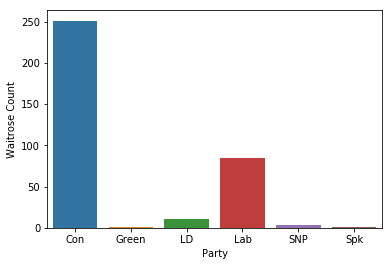

In [16]:
sns.barplot(x='Party', y='Waitrose Count', data=store)

This is OK, but doesn't show how it compares with the picture nationally. So I need to convert it to a percentage of the stores, and then compare it to the percentage of constituencies across the country, to see if it is in proportion or whether it is significant

In [17]:
#Recreate Waitrose count with percentages 
store = df3.groupby(['first_party'], as_index=False).count()
store = store[['first_party', 'Store name']]
store['Store name']=100*(store['Store name']/store['Store name'].sum())
store.columns=['Party','Waitrose Count']
store.set_index('Party')

store.round({'Waitrose Count': 1})


Party  Waitrose Count
0    Con            71.5
1  Green             0.3
2     LD             3.1
3    Lab            23.9
4    SNP             0.9
5    Spk             0.3

Now, we need to create the same chart, but for national figures - taken from the election dataframe we created earlier.

In [18]:

e2 = election.groupby(['first_party'], as_index=False).count()
e2 = e2[['first_party', 'ons_id']]
e2['ons_id']=100*(e2['ons_id']/e2['ons_id'].sum())
e2.round({'ons_id': 1})

first_party  ons_id
0         Con    48.8
1         DUP     1.5
2       Green     0.2
3         Ind     0.2
4          LD     1.8
5         Lab    40.3
6          PC     0.6
7          SF     1.1
8         SNP     5.4
9         Spk     0.2

Join the tables together into a single dataframe.

In [19]:

comparePartiestmp1=store.join(e2[['first_party','ons_id']].set_index('first_party'), on='Party')                 

comparePartiestmp1.columns=['Party','Waitrose', 'National']
comparePartiestmp2 = comparePartiestmp1.round({'Waitrose':1, 'National':1})
comparePartiestmp2

Party  Waitrose  National
0    Con      71.5      48.8
1  Green       0.3       0.2
2     LD       3.1       1.8
3    Lab      23.9      40.3
4    SNP       0.9       5.4
5    Spk       0.3       0.2

In [79]:
pearson_cooef, p_value = stats.pearsonr(comparePartiestmp2['Waitrose'],comparePartiestmp2['National'])
print (pearson_cooef, p_value)

0.9022788308230241 0.013857549776893996


This creates a "long" version of the data table, read to create the seaborn group bar chart:


In [20]:
chart = pd.melt(comparePartiestmp2, id_vars=['Party']).sort_values(['variable','value'], ascending=False)

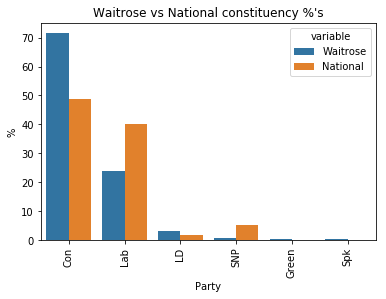

In [21]:
#Now do the plot:
sns.barplot(x='Party', y='value', hue='variable', data=chart)
plt.xticks(rotation=90)
plt.ylabel('%')
plt.title('Waitrose vs National constituency %\'s');

## First conclusion
From the above chart, we can see that Waitrose is distributed amongst more Conservative and Liberal Democrat areas, and less in Labour/SNP areas.

Lets do a similar exercise to show if there is any correlation between deprivation index and where waitrose stores are placed. How to compare the national distribution of deprivation indexes, with the Waitrose distribution? It seems like we could use some binning here:

In [14]:
# min deprivation index is 1 - very deprived, up to 32844.

# Create bins and group names:
bins=np.linspace(1,32844,8)
group_names=['Group 1','Group 2','Group 3','Group 4','Group 5','Group 6','Group 7']

#Add bin columns to national (postcodes) and Waitrose (df3) dataframes:
postcodes['di-binned']=pd.cut(postcodes['Index of Multiple Deprivation'],bins,labels=group_names,include_lowest=True)
df3['di-binned']=pd.cut(df3['Index of Multiple Deprivation'],bins,labels=group_names,include_lowest=True)

# Group by the binned value ready
diNational = postcodes.groupby(['di-binned'], as_index=False).count()
diWaitrose = df3.groupby(['di-binned'], as_index=False).count()

# Change values to %
diNational['Postcode']=100*(diNational['Postcode']/diNational['Postcode'].sum())
diWaitrose['Store name']=100*(diWaitrose['Store name']/diWaitrose['Store name'].sum())

#Join the tables together
compareditmp1=diWaitrose[['di-binned','Store name']].join(diNational[['di-binned','Postcode']].set_index('di-binned'), on='di-binned')                 

compareditmp1.columns=['Group','Waitrose', 'National']
compareditmp2 = compareditmp1.round({'Waitrose':1, 'National':1})
compareditmp2



Group  Waitrose  National
0  Group 1       4.6      25.3
1  Group 2      12.0      14.7
2  Group 3      14.5      12.6
3  Group 4      14.2      12.4
4  Group 5      20.5      12.6
5  Group 6      17.7      11.7
6  Group 7      16.5      10.7

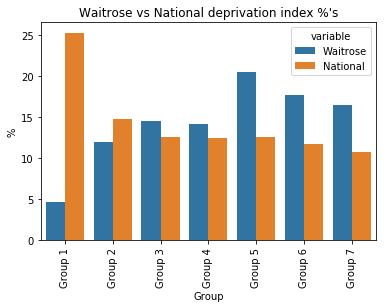

In [15]:
# This creates a "long" version of the data table, read to create the seaborn group bar chart:
chart2 = pd.melt(compareditmp2, id_vars=['Group']).sort_values(['variable','value'], ascending=False)

#Now do the plot:
sns.barplot(x='Group', y='value', hue='variable', data=chart2)
plt.xticks(rotation=90)
plt.ylabel('%')
plt.title('Waitrose vs National deprivation index %\'s');

## Second conclusion
From the chart above, we can see that Waitrose is distributed amongst areas with a lower deprivation index.

We can use this to find an initial list of possible proposed store locations across the country, before then clustering these and fitting the Waitrose stores to the clusters. The cluster where most Waitrose stores fit (ie most similar to existing neighborhoods which contain Waitrose) is where we should look to build new stores.


In [16]:
# Add current party (from 2017 UK elections) into postcode list
postcodes = postcodes.join(election[['ons_id','first_party']].set_index('ons_id'), on='Constituency Code')


Create the initial candidate list of stores by selecting postcodes which are in deprivation groups 5-7 and where the constituency is conservative.

In [102]:
waitrose_initial_candidates_tmp1 = postcodes[postcodes['In Use?'].str.contains('Yes') 
                                             & postcodes['di-binned'].str.contains('Group 5|Group 6|Group 7') 
                                             & postcodes['first_party'].str.contains('Con')]
waitrose_initial_candidates_tmp1.head()


Postcode In Use?   Latitude  Longitude   Easting  Northing  Grid Ref  \
38656   AL11AG     Yes  51.745290  -0.328628  515487.0  206498.0  TL154064   
38658   AL11AJ     Yes  51.744498  -0.328599  515491.0  206410.0  TL154064   
38663   AL11AR     Yes  51.739727  -0.317492  516270.0  205897.0  TL162058   
38664   AL11AS     Yes  51.749073  -0.335471  515005.0  206908.0  TL150069   
38665   AL11AT     Yes  51.742011  -0.319421  516131.0  206148.0  TL161061   

              County   District        Ward     ...      Quality User Type  \
38656  Hertfordshire  St Albans     Sopwell     ...          1.0       0.0   
38658  Hertfordshire  St Albans     Sopwell     ...          1.0       0.0   
38663  Hertfordshire  St Albans  Cunningham     ...          1.0       0.0   
38664  Hertfordshire  St Albans   St Peters     ...          1.0       0.0   
38665  Hertfordshire  St Albans  Cunningham     ...          1.0       0.0   

      Last updated Nearest station Distance to station Postcode area  \
38656   2019-03-28  St.Albans City            0.580683            AL   
38658   2019-03-28  St.Albans City            0.667830            AL   
38663   2019-03-28  St.Albans City            1.379620            AL   
38664   2019-03-28  St.Albans City            0.567432            AL   
38665   2019-03-28  St.Albans City            1.093540            AL   

      Postcode district   Police force di-binned  first_party  
38656               AL1  Hertfordshire   Group 7          Con  
38658               AL1  Hertfordshire   Group 7          Con  
38663               AL1  Hertfordshire   Group 7          Con  
38664               AL1  Hertfordshire   Group 6          Con  
38665               AL1  Hertfordshire   Group 5          Con  

[5 rows x 46 columns]

I don't want to analyse each individual postcode (at road level) - we will look at Postcode districts. We'll use median to get the middle-most lat/lon for each postcode district.

In [18]:
waitrose_initial_candidates = waitrose_initial_candidates_tmp1.groupby('Postcode district', as_index=False).median()
waitrose_initial_candidates.head()


Postcode district   Latitude  Longitude   Easting  Northing  Population  \
0               AL1  51.748475  -0.320944  515991.0  206860.0        33.0   
1              AL10  51.759492  -0.239850  521579.0  208209.0        45.0   
2               AL2  51.720470  -0.351070  514008.0  203757.0        27.0   
3               AL3  51.767798  -0.356803  513539.0  208984.0        22.0   
4               AL4  51.768249  -0.298807  517463.0  209069.5        31.0   

   Households  Altitude  London zone  Index of Multiple Deprivation  Quality  \
0        14.0      97.0          NaN                        29152.0      1.0   
1        15.0      79.0          NaN                        22209.0      1.0   
2        11.0      81.0          NaN                        28123.0      1.0   
3        10.0     113.0          NaN                        29993.0      1.0   
4        12.0      94.0          NaN                        28136.0      1.0   

   User Type  Distance to station  
0        0.0             0.967912  
1        0.0             1.917680  
2        0.0             1.295060  
3        0.0             2.108095  
4        0.0             2.858675

In [19]:
waitrose_initial_candidates.shape

(1514, 13)

Remove from the list of 1514 areas, any Postcode districts which are in the existing Waitrose list.

In [21]:
def isStoreThereAlready(pd):
    yes = False
    if df3[df3['Postcode district'].str.contains(pd)].shape[0]!=0:
        yes = True
    return yes

waitrose_initial_candidates['Already Waitrose'] = waitrose_initial_candidates['Postcode district'].apply(isStoreThereAlready)



In [22]:
waitrose_initial_candidates.head()

Postcode district   Latitude  Longitude   Easting  Northing  Population  \
0               AL1  51.748475  -0.320944  515991.0  206860.0        33.0   
1              AL10  51.759492  -0.239850  521579.0  208209.0        45.0   
2               AL2  51.720470  -0.351070  514008.0  203757.0        27.0   
3               AL3  51.767798  -0.356803  513539.0  208984.0        22.0   
4               AL4  51.768249  -0.298807  517463.0  209069.5        31.0   

   Households  Altitude  London zone  Index of Multiple Deprivation  Quality  \
0        14.0      97.0          NaN                        29152.0      1.0   
1        15.0      79.0          NaN                        22209.0      1.0   
2        11.0      81.0          NaN                        28123.0      1.0   
3        10.0     113.0          NaN                        29993.0      1.0   
4        12.0      94.0          NaN                        28136.0      1.0   

   User Type  Distance to station  Already Waitrose  
0        0.0             0.967912             False  
1        0.0             1.917680             False  
2        0.0             1.295060             False  
3        0.0             2.108095              True  
4        0.0             2.858675             False

In [25]:
waitrose_initial_candidates = waitrose_initial_candidates[waitrose_initial_candidates['Already Waitrose']==False]
del waitrose_initial_candidates['Already Waitrose']


In [26]:
waitrose_initial_candidates.shape

(1197, 13)

Now we have 1197 sites potentially suitable for Waitrose.

We can plot them on a map showing a set of potential Waitrose sites, based on Deprivation Index and political leaning

In [27]:
latitude = 53.414670
longitude = -1.848988
# create map of Waitroses in UK using latitude and longitude values and color dots for party
map_UK = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, postcode in zip(waitrose_initial_candidates['Latitude'], waitrose_initial_candidates['Longitude'], waitrose_initial_candidates['Postcode district']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  


map_UK

## Investigate the neighbourhoods using Foursquare

More investigation of the potential neighbourhoods - clustering them into groups, then seeing which group most Waitrose stores will fit into.  


First, grab the data from Foursquare, and save it locally:  

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        r1 = requests.get(url).json()
        # print (r1)
        results = r1["response"]['groups'][0]['items']
           
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [106]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: xxx
CLIENT_SECRET:xxx


I found the Foursquare API would stop randomly after quite a few calls.  
And starting again made my quota run out.  
So I collected the data in sections, and appended it together at the end - finally saving it all as csv:

In [ ]:

w1300toend=waitrose_initial_candidates_tmp2[1300:]

w1300toend_venues = getNearbyVenues(names=w1300toend['Postcode district'],
                                   latitudes=w1300toend['Latitude'],
                                   longitudes=w1300toend['Longitude']
                                  )

In [30]:
#waitrose_proposed_venues = w0to100_venues.copy()
#waitrose_proposed_venues = waitrose_proposed_venues.append(w100to200_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w200to300_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w300to500_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w500to700_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w700to900_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w900to1100_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w1100to1300_venues)
#waitrose_proposed_venues = waitrose_proposed_venues.append(w1300toend_venues)
#waitrose_proposed_venues.to_csv("waitrose_proposed_venues.csv") #- commented now so I don't accidentally overwrite later

waitrose_proposed_venues = pd.read_csv("waitrose_proposed_venues.csv")
waitrose_proposed_venues.head()


Unnamed: 0 Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0          AL1              51.748475               -0.320944   
1           1          AL1              51.748475               -0.320944   
2           2          AL1              51.748475               -0.320944   
3           3          AL1              51.748475               -0.320944   
4           4          AL1              51.748475               -0.320944   

              Venue  Venue Latitude  Venue Longitude            Venue Category  
0         Med Grill       51.752137        -0.320707  Mediterranean Restaurant  
1         The Crown       51.751278        -0.323276                       Pub  
2  Lebanese Kitchen       51.751080        -0.323537       Lebanese Restaurant  
3        Chilli Raj       51.751223        -0.323385         Indian Restaurant  
4     Tesco Express       51.752260        -0.320261             Grocery Store

In [31]:
waitrose_proposed_venues.shape

(7681, 8)

Lets see the top venues around our selected areas:

In [54]:
waitrose_proposed_venues.groupby('Venue Category').count().sort_values(['Neighborhood'], ascending=False)


Unnamed: 0  Neighborhood  Neighborhood Latitude  \
Venue Category                                                                
Pub                                741           741                    741   
Coffee Shop                        409           409                    409   
Grocery Store                      332           332                    332   
Hotel                              299           299                    299   
Café                               263           263                    263   
Italian Restaurant                 215           215                    215   
Restaurant                         190           190                    190   
Indian Restaurant                  166           166                    166   
Park                               158           158                    158   
Gym / Fitness Center               154           154                    154   
Supermarket                        151           151                    151   
Sandwich Place                     138           138                    138   
Convenience Store                  122           122                    122   
Pizza Place                        108           108                    108   
Fast Food Restaurant               106           106                    106   
Bar                                106           106                    106   
French Restaurant                  106           106                    106   
Construction & Landscaping          95            95                     95   
Fish & Chips Shop                   92            92                     92   
Bakery                              87            87                     87   
Train Station                       87            87                     87   
Clothing Store                      78            78                     78   
Chinese Restaurant                  77            77                     77   
Gastropub                           74            74                     74   
Pharmacy                            74            74                     74   
Cocktail Bar                        64            64                     64   
Wine Bar                            59            59                     59   
Seafood Restaurant                  53            53                     53   
Steakhouse                          53            53                     53   
Japanese Restaurant                 49            49                     49   
...                                ...           ...                    ...   
Shop & Service                       1             1                      1   
Shipping Store                       1             1                      1   
Scottish Restaurant                  1             1                      1   
School                               1             1                      1   
Road                                 1             1                      1   
Resort                               1             1                      1   
Reservoir                            1             1                      1   
Record Shop                          1             1                      1   
RV Park                              1             1                      1   
Pier                                 1             1                      1   
Pie Shop                             1             1                      1   
Pakistani Restaurant                 1             1                      1   
Paella Restaurant                    1             1                      1   
Outlet Store                         1             1                      1   
National Park                        1             1                      1   
Mountain                             1             1                      1   
Moroccan Restaurant                  1             1                      1   
Metro Station                        1             1                      1   

Now we have the list of Neighbourhoods and their venues, time to one-hot-encode it, so we can create a K-means model from it.


In [32]:
# one hot encoding
waitrose_proposed_onehot = pd.get_dummies(waitrose_proposed_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
waitrose_proposed_onehot['Neighborhood'] = waitrose_proposed_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [waitrose_proposed_onehot.columns[-1]] + list(waitrose_proposed_onehot.columns[:-1])
waitrose_proposed_onehot = waitrose_proposed_onehot[fixed_columns]
del waitrose_proposed_onehot['Supermarket']

waitrose_proposed_onehot.head()

Zoo  Accessories Store  Adult Education Center  Airport  \
0    0                  0                       0        0   
1    0                  0                       0        0   
2    0                  0                       0        0   
3    0                  0                       0        0   
4    0                  0                       0        0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum     ...       Watch Shop  Water Park  \
0            0           0     ...                0           0   
1            0           0     ...                0           0   
2            0           0     ...                0           0   
3            0           0     ...                0           0   
4            0           0     ...                0           0   

   Weight Loss Center  Whisky Bar  Windmill  Wine Bar  Wine Shop  Wings Joint  \
0                   0           0         0         0          0            0   
1                   0           0         0         0          0            0   
2                   0           0         0         0          0            0   
3                   0           0         0         0          0            0   
4                   0           0         0         0          0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 374 columns]

Now we group it by Neighbourhood (ie Postal district)

In [104]:

waitrose_proposed_grouped = waitrose_proposed_onehot.groupby('Neighborhood').mean().reset_index()

waitrose_proposed_grouped


Neighborhood  Zoo  Accessories Store  Adult Education Center  Airport  \
0            AL1  0.0                0.0                     0.0      0.0   
1           AL10  0.0                0.0                     0.0      0.0   
2            AL2  0.0                0.0                     0.0      0.0   
3            AL4  0.0                0.0                     0.0      0.0   
4            AL7  0.0                0.0                     0.0      0.0   
5            AL9  0.0                0.0                     0.0      0.0   
6            B14  0.0                0.0                     0.0      0.0   
7            B23  0.0                0.0                     0.0      0.0   
8            B26  0.0                0.0                     0.0      0.0   
9            B27  0.0                0.0                     0.0      0.0   
10           B36  0.0                0.0                     0.0      0.0   
11           B42  0.0                0.0                     0.0      0.0   
12           B44  0.0                0.0                     0.0      0.0   
13           B45  0.0                0.0                     0.0      0.0   
14           B46  0.0                0.0                     0.0      0.0   
15           B47  0.0                0.0                     0.0      0.0   
16           B48  0.0                0.0                     0.0      0.0   
17           B50  0.0                0.0                     0.0      0.0   
18           B60  0.0                0.0                     0.0      0.0   
19           B62  0.0                0.0                     0.0      0.0   
20           B63  0.0                0.0                     0.0      0.0   
21           B64  0.0                0.0                     0.0      0.0   
22           B65  0.0                0.0                     0.0      0.0   
23           B69  0.0                0.0                     0.0      0.0   
24           B72  0.0                0.0                     0.0      0.0   
25           B73  0.0                0.0                     0.0      0.0   
26           B75  0.0                0.0                     0.0      0.0   
27           B76  0.0                0.0                     0.0      0.0   
28           B77  0.0                0.0                     0.0      0.0   
29           B78  0.0                0.0                     0.0      0.0   
..           ...  ...                ...                     ...      ...   
970         WV11  0.0                0.0                     0.0      0.0   
971         WV12  0.0                0.0                     0.0      0.0   
972         WV15  0.0                0.0                     0.0      0.0   
973         WV16  0.0                0.0                     0.0      0.0   
974          WV3  0.0                0.0                     0.0      0.0   
975          WV4  0.0                0.0                     0.0      0.0   
976          WV5  0.0                0.0                     0.0      0.0   
977          WV6  0.0                0.0                     0.0      0.0   
978          WV7  0.0                0.0                     0.0      0.0   
979          WV8  0.0                0.0                     0.0      0.0   
980          WV9  0.0                0.0                     0.2      0.0   
981         WV98  0.0                0.0                     0.0      0.0   
982         YO10  0.0                0.0                     0.0      0.0   
983         YO11  0.0                0.0                     0.0      0.0   
984         YO12  0.0                0.0                     0.0      0.0   
985         YO14  0.0                0.0                     0.0      0.0   
986         YO15  0.0                0.0                     0.0      0.0   
987         YO16  0.0                0.0                     0.0      0.0   
988         YO17  0.0                0.0                     0.0      0.0   
989         YO18  0.0                0.0                     0.0      0.0   


Fit the grouped one hot encoded data to the KMeans model, and the data will group into clusters.

In [35]:
kclusters = 5

waitrose_proposed_grouped_clustering = waitrose_proposed_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_proposed = KMeans(n_clusters=kclusters, random_state=0).fit(waitrose_proposed_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_proposed.labels_[0:10] 


array([4, 4, 2, 2, 0, 4, 4, 3, 4, 4], dtype=int32)

See which venues are the msot common around the areas. We can later see which of these groups the Waitrose stores fits into


In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
waitrose_proposed_venues_sorted = pd.DataFrame(columns=columns)
waitrose_proposed_venues_sorted['Neighborhood'] = waitrose_proposed_grouped['Neighborhood']

for ind in np.arange(waitrose_proposed_grouped.shape[0]):
    waitrose_proposed_venues_sorted.iloc[ind, 1:] = return_most_common_venues(waitrose_proposed_grouped.iloc[ind, :], num_top_venues)

waitrose_proposed_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          AL1    Italian Restaurant   Lebanese Restaurant   
1         AL10     Indian Restaurant           Coffee Shop   
2          AL2     Fish & Chips Shop         Grocery Store   
3          AL4     Fish & Chips Shop         Grocery Store   
4          AL7                Market     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Building                  Café  Fast Food Restaurant   
1        Clothing Store        Sandwich Place                 Hotel   
2          Liquor Store                  Park               Exhibit   
3    Chinese Restaurant          Home Service  Gym / Fitness Center   
4                   Pub   Arts & Crafts Store           Yoga Studio   

        6th Most Common Venue     7th Most Common Venue 8th Most Common Venue  \
0               Grocery Store  Mediterranean Restaurant    Chinese Restaurant   
1        Fast Food Restaurant           Bubble Tea Shop             Bookstore   
2          Falafel Restaurant                      Farm        Farmers Market   
3  Financial or Legal Service                   Factory    Falafel Restaurant   
4                 Fish Market        Falafel Restaurant                  Farm   

  9th Most Common Venue 10th Most Common Venue  
0        Breakfast Spot                    Pub  
1     Mobile Phone Shop          Movie Theater  
2  Fast Food Restaurant                  Field  
3                  Farm         Farmers Market  
4        Farmers Market   Fast Food Restaurant

Now add clustering labels...

In [39]:

waitrose_proposed_venues_sorted.insert(0, 'Cluster Labels', kmeans_proposed.labels_)

Now we have all the data including cluster labels in a table:

In [40]:
waitrose_proposed_merged = waitrose_initial_candidates.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
waitrose_proposed_merged = waitrose_proposed_merged.join(waitrose_proposed_venues_sorted.set_index('Neighborhood'), on='Postcode district')

#Only take rows where the clustering is not NaN
waitrose_proposed_merged = waitrose_proposed_merged[np.isfinite(waitrose_proposed_merged['Cluster Labels'])]

#del waitrose_proposed_merged['Unnamed: 0.1']
waitrose_proposed_merged[['Postcode district', 'Latitude', 'Longitude', 'Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']].head()



Postcode district   Latitude  Longitude  Cluster Labels  \
0               AL1  51.748475  -0.320944             4.0   
1              AL10  51.759492  -0.239850             4.0   
2               AL2  51.720470  -0.351070             2.0   
4               AL4  51.768249  -0.298807             2.0   
7               AL7  51.795069  -0.186096             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
0    Italian Restaurant   Lebanese Restaurant              Building  
1     Indian Restaurant           Coffee Shop        Clothing Store  
2     Fish & Chips Shop         Grocery Store          Liquor Store  
4     Fish & Chips Shop         Grocery Store    Chinese Restaurant  
7                Market     Convenience Store                   Pub

In [41]:
waitrose_proposed_merged.shape

(1000, 24)

How many in each cluster? 

In [68]:
waitrose_proposed_merged.groupby(['Cluster Labels']).count()

Postcode district  Latitude  Longitude  Easting  Northing  \
Cluster Labels                                                              
0.0                            59        59         59       59        59   
1.0                            37        37         37       37        37   
2.0                            95        95         95       95        95   
3.0                           283       283        283      283       283   
4.0                           526       526        526      526       526   

                Population  Households  Altitude  London zone  \
Cluster Labels                                                  
0.0                     59          59        59            1   
1.0                     37          37        37            0   
2.0                     93          93        95            4   
3.0                    274         274       283           13   
4.0                    496         496       526           58   

                Index of Multiple Deprivation           ...            \
Cluster Labels                                          ...             
0.0                                        59           ...             
1.0                                        37           ...             
2.0                                        95           ...             
3.0                                       283           ...             
4.0                                       526           ...             

                1st Most Common Venue  2nd Most Common Venue  \
Cluster Labels                                                 
0.0                                59                     59   
1.0                                37                     37   
2.0                                95                     95   
3.0                               283                    283   
4.0                               526                    526   

                3rd Most Common Venue  4th Most Common Venue  \
Cluster Labels                                                 
0.0                                59                     59   
1.0                                37                     37   
2.0                                95                     95   
3.0                               283                    283   
4.0                               526                    526   

                5th Most Common Venue  6th Most Common Venue  \
Cluster Labels                                                 
0.0                                59                     59   
1.0                                37                     37   
2.0                                95                     95   
3.0                               283                    283   
4.0                               526                    526   

                7th Most Common Venue  8th Most Common Venue  \
Cluster Labels                                                 
0.0                                59                     59   
1.0                                37                     37   
2.0                                95                     95   
3.0                               283                    283   
4.0                               526                    526   

                9th Most Common Venue  10th Most Common Venue  
Cluster Labels                                                 
0.0                                59                      59  
1.0                                37                      37  
2.0                                95                      95  
3.0                               283                     283  
4.0                               526                     526  

[5 rows x 23 columns]

Now, let's map the 1000 potential sites, showing the clusters 0-4 as different colors

In [42]:
latitude = 53.414670
longitude = -1.848988
# create map of Waitroses in UK using latitude and longitude values and color dots for party
map_UK = folium.Map(location=[latitude, longitude], zoom_start=6)
colorDot = ({})
colorDot[0]='white'
colorDot[1]='pink'
colorDot[2]='red'
colorDot[3]='magenta'
colorDot[4]='black'

# add markers to map
for lat, lng,  postcode, cluster in zip(waitrose_proposed_merged['Latitude'], waitrose_proposed_merged['Longitude'], waitrose_proposed_merged['Postcode district'], waitrose_proposed_merged['Cluster Labels']):
    #print (lat, lng, postcode, cluster)
    label = 'Postal district: {}'.format( postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorDot[cluster],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  

map_UK

## Doing the prediction

Now we can try to apply these clusters to our Waitrose stores. First we get venue data for our stores. Then we fit our data to the shape of the model. It doesn't work initially, so we have to add some extra columns into the one-hot-encoding table.

In [ ]:
waitrose_venues = getNearbyVenues(names=df3['Store name'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

In [45]:
# Saving waitrose venues to csv so I don't use up foursquare calls if I need to reload: 
# waitrose_venues.to_csv("waitrose_venues.csv")
waitrose_venues = pd.read_csv("waitrose_venues.csv")
waitrose_venues.head()

Unnamed: 0 Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Abergavenny              51.818294               -3.028245   
1           1  Abergavenny              51.818294               -3.028245   
2           2     Abingdon              51.672083               -1.279705   
3           3     Abingdon              51.672083               -1.279705   
4           4     Abingdon              51.672083               -1.279705   

                           Venue  Venue Latitude  Venue Longitude  \
0            Waitrose & Partners       51.816618        -3.028439   
1  Eisteddfod Genedlaethol Cymru       51.819460        -3.023319   
2              Crown and Thistle       51.669604        -1.280457   
3                   Costa Coffee       51.670426        -1.281812   
4            Waitrose & Partners       51.672038        -1.279792   

          Venue Category  
0            Supermarket  
1  Performing Arts Venue  
2                    Pub  
3            Coffee Shop  
4            Supermarket

Remove rows where venue is Waitrose and Partners, otherwise we are looking at ourselves in the data. Hmm, perhaps I should have started here rather than web scraping! (Though it wouldn't show the difference between John Lewis Stores and Waitroses)

In [48]:
waitrose_venues = waitrose_venues[waitrose_venues['Venue']!='Waitrose & Partners']
waitrose_venues.head()

Unnamed: 0 Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
1           1  Abergavenny              51.818294               -3.028245   
2           2     Abingdon              51.672083               -1.279705   
3           3     Abingdon              51.672083               -1.279705   
5           5     Abingdon              51.672083               -1.279705   
6           6     Abingdon              51.672083               -1.279705   

                           Venue  Venue Latitude  Venue Longitude  \
1  Eisteddfod Genedlaethol Cymru       51.819460        -3.023319   
2              Crown and Thistle       51.669604        -1.280457   
3                   Costa Coffee       51.670426        -1.281812   
5                  The Nags Head       51.668649        -1.279253   
6                          Chaba       51.670013        -1.283104   

          Venue Category  
1  Performing Arts Venue  
2                    Pub  
3            Coffee Shop  
5                    Pub  
6        Thai Restaurant

In [49]:
waitrose_venues.shape

(9696, 8)

In [50]:
waitrose_venues.groupby('Venue Category').count().sort_values(['Neighborhood'], ascending=False)


Unnamed: 0  Neighborhood  Neighborhood Latitude  \
Venue Category                                                             
Pub                             819           819                    819   
Coffee Shop                     786           786                    786   
Café                            456           456                    456   
Italian Restaurant              389           389                    389   
Hotel                           358           358                    358   
Grocery Store                   293           293                    293   
Pizza Place                     270           270                    270   
Bar                             232           232                    232   
Sandwich Place                  222           222                    222   
Indian Restaurant               211           211                    211   
Bakery                          188           188                    188   
Bookstore                       188           188                    188   
Clothing Store                  177           177                    177   
Pharmacy                        160           160                    160   
Supermarket                     160           160                    160   
Fast Food Restaurant            139           139                    139   
Restaurant                      138           138                    138   
Park                            131           131                    131   
Burger Joint                    126           126                    126   
Gym / Fitness Center            124           124                    124   
Thai Restaurant                 109           109                    109   
French Restaurant               106           106                    106   
Chinese Restaurant               91            91                     91   
Sushi Restaurant                 83            83                     83   
Gastropub                        81            81                     81   
English Restaurant               77            77                     77   
Cocktail Bar                     76            76                     76   
Asian Restaurant                 71            71                     71   
Plaza                            68            68                     68   
Furniture / Home Store           68            68                     68   
...                             ...           ...                    ...   
Sculpture Garden                  1             1                      1   
Satay Restaurant                  1             1                      1   
Salon / Barbershop                1             1                      1   
Rugby Stadium                     1             1                      1   
Other Repair Shop                 1             1                      1   
Rugby Pitch                       1             1                      1   
Pier                              1             1                      1   
Roller Rink                       1             1                      1   
Pilates Studio                    1             1                      1   
River                             1             1                      1   
Rest Area                         1             1                      1   
Border Crossing                   1             1                      1   
Other Great Outdoors              1             1                      1   
College Arts Building             1             1                      1   
Chaat Place                       1             1                      1   
Lighting Store                    1             1                      1   
Churrascaria                      1             1                      1   
Public Art                        1             1                      1   
Medical Center                    1             1                      1   
Memorial Site                     1             1                      1 

## Observation 
Waitrose like to place themselves amongst Pubs, coffee shops and restaurants.   

Now we will get organise the Waitrose venue data for passing to the K-means cluster model, by one hot encoding it

In [55]:
# one hot encoding
waitrose_onehot = pd.get_dummies(waitrose_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
waitrose_onehot['Neighborhood'] = waitrose_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [waitrose_onehot.columns[-1]] + list(waitrose_onehot.columns[:-1])
waitrose_onehot = waitrose_onehot[fixed_columns]
del waitrose_onehot['Supermarket']

waitrose_onehot.head()


Neighborhood  Accessories Store  Adult Boutique  Advertising Agency  \
1  Abergavenny                  0               0                   0   
2     Abingdon                  0               0                   0   
3     Abingdon                  0               0                   0   
5     Abingdon                  0               0                   0   
6     Abingdon                  0               0                   0   

   Afghan Restaurant  African Restaurant  American Restaurant  Animal Shelter  \
1                  0                   0                    0               0   
2                  0                   0                    0               0   
3                  0                   0                    0               0   
5                  0                   0                    0               0   
6                  0                   0                    0               0   

   Antique Shop  Arcade     ...       Vietnamese Restaurant  Warehouse Store  \
1             0       0     ...                           0                0   
2             0       0     ...                           0                0   
3             0       0     ...                           0                0   
5             0       0     ...                           0                0   
6             0       0     ...                           0                0   

   Waterfall  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
1          0           0         0          0            0              0   
2          0           0         0          0            0              0   
3          0           0         0          0            0              0   
5          0           0         0          0            0              0   
6          0           0         0          0            0              0   

   Yakitori Restaurant  Yoga Studio  
1                    0            0  
2                    0            0  
3                    0            0  
5                    0            0  
6                    0            0  

[5 rows x 350 columns]

In [57]:
waitrose_grouped = waitrose_onehot.groupby('Neighborhood').mean().reset_index()
waitrose_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  Advertising Agency  \
0    Abergavenny                0.0             0.0                 0.0   
1       Abingdon                0.0             0.0                 0.0   
2     Addlestone                0.0             0.0                 0.0   
3       Alcester                0.0             0.0                 0.0   
4  Alderley Edge                0.0             0.0                 0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Animal Shelter  \
0                0.0                 0.0             0.000000             0.0   
1                0.0                 0.0             0.000000             0.0   
2                0.0                 0.0             0.000000             0.0   
3                0.0                 0.0             0.000000             0.0   
4                0.0                 0.0             0.052632             0.0   

   Antique Shop  Arcade     ...       Vietnamese Restaurant  Warehouse Store  \
0           0.0     0.0     ...                         0.0              0.0   
1           0.0     0.0     ...                         0.0              0.0   
2           0.0     0.0     ...                         0.0              0.0   
3           0.0     0.0     ...                         0.0              0.0   
4           0.0     0.0     ...                         0.0              0.0   

   Waterfall  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0        0.0         0.0  0.000000        0.0          0.0            0.0   
1        0.0         0.0  0.000000        0.0          0.0            0.0   
2        0.0         0.0  0.000000        0.0          0.0            0.0   
3        0.0         0.0  0.000000        0.0          0.0            0.0   
4        0.0         0.0  0.052632        0.0          0.0            0.0   

   Yakitori Restaurant  Yoga Studio  
0                  0.0          0.0  
1                  0.0          0.0  
2                  0.0          0.0  
3                  0.0          0.0  
4                  0.0          0.0  

[5 rows x 350 columns]

Let's list the top most common venues around Waitrose stores:

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
waitrose_venues_sorted = pd.DataFrame(columns=columns)
waitrose_venues_sorted['Neighborhood'] = waitrose_grouped['Neighborhood']

for ind in np.arange(waitrose_grouped.shape[0]):
    waitrose_venues_sorted.iloc[ind, 1:] = return_most_common_venues(waitrose_grouped.iloc[ind, :], num_top_venues)

waitrose_venues_sorted.head()

Neighborhood  1st Most Common Venue 2nd Most Common Venue  \
0    Abergavenny  Performing Arts Venue           Yoga Studio   
1       Abingdon                    Pub                  Park   
2     Addlestone                   Café                  Park   
3       Alcester                    Pub     Indian Restaurant   
4  Alderley Edge     Italian Restaurant     French Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Film Studio           Event Space               Exhibit   
1       Thai Restaurant                Bakery             Bookstore   
2                 Hotel        Sandwich Place                Bakery   
3  Gym / Fitness Center         Grocery Store              Tea Room   
4         Grocery Store                   Pub                 Hotel   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Falafel Restaurant                  Farm        Farmers Market   
1              Pharmacy           Gas Station           Coffee Shop   
2    Chinese Restaurant  Fast Food Restaurant           Coffee Shop   
3                   Bar        Farmers Market  Ethiopian Restaurant   
4                  Park           Coffee Shop            Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0  Fast Food Restaurant    Filipino Restaurant  
1              Tea Room                   Café  
2       Thai Restaurant      Indian Restaurant  
3           Event Space                Exhibit  
4                Bakery                   Café

Now we will try and fit the one-hot grouped data to the KMeans cluster

In [61]:
kclusters = 5

waitrose_grouped_cluster = waitrose_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_waitrose = kmeans_proposed.predict(waitrose_grouped_cluster)
# check cluster labels generated for each row in the dataframe
kmeans_waitrose.labels_[0:10] 

ValueError: Incorrect number of features. Got 349 features, expected 373

This didn't work as we have an incorrect number of features, so will add the ones not in the table already


In [62]:
for item in waitrose_proposed_grouped_clustering.columns:
    if item not in waitrose_grouped_cluster.columns:
        waitrose_grouped_cluster[item] = 0

In [63]:
# run k-means clustering
kmeans_waitrose = kmeans_proposed.predict(waitrose_grouped_cluster)
# check cluster labels generated for each row in the dataframe
kmeans_waitrose.labels_[0:10]

ValueError: Incorrect number of features. Got 431 features, expected 373

Now we have too many features, so removing the extras:

In [64]:
for item in waitrose_grouped_cluster.columns:
    if item not in waitrose_proposed_grouped_clustering.columns:
        del waitrose_grouped_cluster[item]

Now we should have items which overlap between our proposed sites and the actual waitrose sites.

In [66]:
# run k-means clustering
kmeans_waitrose = kmeans_proposed.predict(waitrose_grouped_cluster)
# check cluster labels generated for each row in the dataframe
kmeans_waitrose

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

## Wow... 
Almost all the Waitrose stores fit into cluster 4. Without much more analysis, lets plot the proposed sites again, but this time, only cluster 4

In [73]:
waitrose_proposed_cluster4 = waitrose_proposed_merged[waitrose_proposed_merged['Cluster Labels']==4]

And now add our existing stores for reference

In [94]:
waitroseAll = waitrose_proposed_cluster4.append(df3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [79]:
waitroseAll.shape

(877, 34)

Ready for putting on the map, I'm changing the cluster label for our existing stores, which don't have a cluster label, to 99, so they can be different color dots.

In [95]:
def setNanTo99(val):
    if not np.isfinite(val):
        val=99
    return val

waitroseAll['Cluster Labels'] = waitroseAll['Cluster Labels'].apply(setNanTo99)

In [98]:
waitroseAll.groupby(['Cluster Labels']).count()
#waitroseAll

10th Most Common Venue  1st Most Common Venue  \
Cluster Labels                                                  
4.0                                526                    526   
99.0                                 0                      0   

                2nd Most Common Venue  3rd Most Common Venue  \
Cluster Labels                                                 
4.0                               526                    526   
99.0                                0                      0   

                4th Most Common Venue  5th Most Common Venue  \
Cluster Labels                                                 
4.0                               526                    526   
99.0                                0                      0   

                6th Most Common Venue  7th Most Common Venue  \
Cluster Labels                                                 
4.0                               526                    526   
99.0                                0                      0   

                8th Most Common Venue  9th Most Common Venue     ...       \
Cluster Labels                                                   ...        
4.0                               526                    526     ...        
99.0                                0                      0     ...        

                Postcode  Postcode district  Quality  Store URL  Store name  \
Cluster Labels                                                                
4.0                    0                526      526          0           0   
99.0                 351                351        0        351         351   

                Unnamed: 0  Unnamed: 0.1  User Type  di-binned  first_party  
Cluster Labels                                                               
4.0                      0             0        526          0            0  
99.0                   351           351          0        351          351  

[2 rows x 33 columns]

Now we can plot the proposed and current stores on the map together - existing stores in blue, new ones in red

In [100]:
latitude = 53.414670
longitude = -1.848988
# create map of Waitroses in UK using latitude and longitude values and color dots for party
map_UK = folium.Map(location=[latitude, longitude], zoom_start=6)
colorDot = ({})
colorDot[99]='blue'
colorDot[4]='red'

# add markers to map
for lat, lng,  storename, cluster in zip(waitroseAll['Latitude'], waitroseAll['Longitude'], waitroseAll['Store name'], waitroseAll['Cluster Labels']):
   # print (lat, lng, postcode, cluster)
    label = 'Store name: {}'.format( storename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorDot[cluster],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_UK)  

map_UK

That's it. I am really surprised that Bishops Waltham and New Alresford don't already have Waitroses, so I guess there must be something in the result!